In [330]:
# Initialize Otter
import otter
grader = otter.Notebook("hw02.ipynb")

# Homework 2: Food Safety
## Cleaning and Exploring Data with Pandas
## Due Date: Thursday, September 8, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*


## This Assignment

In this homework, we will investigate restaurant food safety scores for restaurants in San Francisco. The scores and violation information has been [made available by the San Francisco Department of Public Health](https://data.sfgov.org/Health-and-Social-Services/Restaurant-Scores-LIVES-Standard/pyih-qa8i). The main goal for this assignment is to walk through the process of Data Cleaning and EDA. 


As we clean and explore these data, you will gain practice with:
* Reading simple csv files and using Pandas
* Working with data at different levels of granularity
* Identifying the type of data collected, missing values, anomalies, etc.
* Exploring characteristics and distributions of individual variables

## Score Breakdown 
Question | Points
--- | ---
1a | 1
1b | 2
1c | 1
2a | 2
2b | 2
2ci | 1
2cii | 1
2d | 2
2e | 2
2f | 2
3a | 1
3bi | 2
3ci | 1
3cii | 1
3ciii | 1
3civ | 1
3d | 3
4a | 2
4b | 3
4c | 2
5a|1
5b|2
6a|3
6b|2
6c|2
7|0
Total | 43

## Before You Start

For each question in the assignment, please write down your answer in the answer cell(s) right below the question. 

We understand that it is helpful to have extra cells breaking down the process towards reaching your final answer. If you happen to create new cells below your answer to run codes, **NEVER** add cells between a question cell and the answer cell below it. It will cause errors when we run the autograder, and it will sometimes cause a failure to generate the PDF file.

**Important note: The local autograder tests will not be comprehensive. You can pass the automated tests in your notebook but still fail tests in the autograder.** Please be sure to check your results carefully.

Finally, unless we state otherwise, **do not use for loops or list comprehensions**. The majority of this assignment can be done using builtin commands in Pandas and numpy.  Our autograder isn't smart enough to check, but you're depriving yourself of key learning objectives if you write loops / comprehensions, and you also won't be ready for the midterm.


In [331]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('fivethirtyeight')

import zipfile
from pathlib import Path

import os
import plotly

from IPython.display import display, Image 
def display_figure_for_grader(fig):
    plotly.io.write_image(fig, 'temp.png')
    display(Image('temp.png'))    

## Obtaining the Data

### File Systems and I/O



In general, we will focus on using python commands to investigate files.  However, it can sometimes be easier to use shell commands in your local operating system.  The following cells demonstrate how to do this.

In [332]:
from pathlib import Path
data_dir = Path('.')
data_dir.mkdir(exist_ok = True)
file_path = data_dir / Path('data.zip')
dest_path = file_path

After running the cell above, if you list the contents of the directory containing this notebook, you should see `data.zip`.

*Note*: The command below starts with an `!`. This tells our Jupyter notebook to pass this command to the operating system. In this case, the command is the `ls` Unix command which lists files in the current directory.

In [333]:
!ls

data		hw02_2022_09_10T00_35_04_220431.zip  pics
data.zip	hw02_2022_09_10T00_38_59_137892.zip  __pycache__
ds100_utils.py	hw02.ipynb


## 1: Loading Food Safety Data

We have data, but we don't have any specific questions about the data yet. Let's focus on understanding the structure of the data; this involves answering questions such as:

* Is the data in a standard format or encoding?
* Is the data organized in records?
* What are the fields in each record?

Let's start by looking at the contents of `data.zip`. It's not just a single file but rather a compressed directory of multiple files. We could inspect it by uncompressing it using a shell command such as `!unzip data.zip`, but in this homework we're going to do almost everything in Python for maximum portability.

## Looking Inside and Extracting the Zip Files

The following codeblocks are setup. Simply run the cells; **do not modify them**. Question 1a is where you will start to write code.

Here, we assign `my_zip` to a `zipfile.Zipfile` object representing `data.zip`, and assign `list_names` to a list of all the names of the contents in `data.zip`.

In [334]:
my_zip = zipfile.ZipFile(dest_path, 'r')
list_names = my_zip.namelist()
list_names

['data/',
 'data/bus.csv',
 'data/ins.csv',
 'data/ins2vio.csv',
 'data/vio.csv',
 'data/sf_zipcodes.json',
 'data/legend.csv']

You may notice that we did not write `zipfile.ZipFile('data.zip', ...)`. Instead, we used `zipfile.ZipFile(dest_path, ...)`. In general, we **strongly suggest having your filenames hard coded as string literals only once** in a notebook. It is very dangerous to hard code things twice because if you change one but forget to change the other, you can end up with bugs that are very hard to find.

Now we display the files' names and their sizes.

In [335]:
my_zip = zipfile.ZipFile(dest_path, 'r')
for info in my_zip.infolist():
    print('{}\t{}'.format(info.filename, info.file_size))

data/	0
data/bus.csv	665365
data/ins.csv	1860919
data/ins2vio.csv	1032799
data/vio.csv	4213
data/sf_zipcodes.json	474
data/legend.csv	120


Often when working with zipped data, we'll never unzip the actual zipfile. This saves space on our local computer. However, for this homework the files are small, so we're just going to unzip everything. This has the added benefit that you can look inside the csv files using a text editor, which might be handy for understanding the structure of the files. The cell below will unzip the csv files into a subdirectory called `data`.

In [336]:
data_dir = Path('.')
my_zip.extractall(data_dir)
!ls {data_dir / Path("data")}

bus.csv  ins2vio.csv  ins.csv  legend.csv  sf_zipcodes.json  vio.csv


The cell above created a folder called `data`, and in it there should be five CSV files. Let's open up `legend.csv` to see its contents. To do this, click on the jupyterhub logo on the top left, then navigate to `fa22/hw/hw3/data/` and click on `legend.csv`. The file will open up in another tab. You should see something that looks like:

    "Minimum_Score","Maximum_Score","Description"
    0,70,"Poor"
    71,85,"Needs Improvement"
    86,90,"Adequate"
    91,100,"Good"

The `legend.csv` file does indeed look like a well-formed CSV file. Let's check the other three files. Rather than opening up each file manually, let's use Python to print out the first 5 lines of each. The `ds100_utils` library has a method called `head` that will allow you to retrieve the first N lines of a file as a list. For example `ds100_utils.head('data/legend.csv', 5)` will return the first 5 lines of "data/legend.csv". Try using this function to print out the first 5 lines of all six files that we just extracted from the zipfile.

In [337]:
import ds100_utils

data_dir = "./"
for f in list_names:
    if not os.path.isdir(f):
        print(ds100_utils.head(data_dir + f, 5), "\n")

['"business id column","name","address","city","state","postal_code","latitude","longitude","phone_number"\n', '"1000","HEUNG YUEN RESTAURANT","3279 22nd St","San Francisco","CA","94110","37.755282","-122.420493","-9999"\n', '"100010","ILLY CAFFE SF_PIER 39","PIER 39  K-106-B","San Francisco","CA","94133","-9999","-9999","+14154827284"\n', '"100017","AMICI\'S EAST COAST PIZZERIA","475 06th St","San Francisco","CA","94103","-9999","-9999","+14155279839"\n', '"100026","LOCAL CATERING","1566 CARROLL AVE","San Francisco","CA","94124","-9999","-9999","+14155860315"\n'] 

['"iid","date","score","type"\n', '"100010_20190329","03/29/2019 12:00:00 AM","-1","New Construction"\n', '"100010_20190403","04/03/2019 12:00:00 AM","100","Routine - Unscheduled"\n', '"100017_20190417","04/17/2019 12:00:00 AM","-1","New Ownership"\n', '"100017_20190816","08/16/2019 12:00:00 AM","91","Routine - Unscheduled"\n'] 

['"iid","vid"\n', '"97975_20190725","103124"\n', '"85986_20161011","103114"\n', '"95754_2019032

## Reading in and Verifying Data

Based on the above information, let's attempt to load `bus.csv`, `ins2vio.csv`, `ins.csv`, and `vio.csv` into pandas dataframes with the following names: `bus`, `ins2vio`, `ins`, and `vio` respectively.

*Note:* Because of character encoding issues one of the files (`bus`) will require an additional argument `encoding='ISO-8859-1'` when calling `pd.read_csv`. At some point in your future, you should read all about [character encodings](https://diveintopython3.problemsolving.io/strings.html). We won't discuss these in detail in Data 100.

In [338]:
# path to directory containing data
dsDir = Path('data')

bus = pd.read_csv(dsDir/'bus.csv', encoding='ISO-8859-1')
ins2vio = pd.read_csv(dsDir/'ins2vio.csv')
ins = pd.read_csv(dsDir/'ins.csv')
vio = pd.read_csv(dsDir/'vio.csv')

#This code is essential for the autograder to function properly. Do not edit
ins_test = ins

Now that you've read in the files, let's try some `pd.DataFrame` methods ([docs](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.html)).
Use the `DataFrame.head` method to show the top few lines of the `bus`, `ins`, and `vio` dataframes. For example, running the cell below will display the first few lines of the `bus` dataframe. 

In [339]:
bus.head()

,business id column,name,address,city,state,postal_code,latitude,longitude,phone_number
0,1000,HEUNG YUEN RESTAURANT,3279 22nd St,San Francisco,CA,94110,37.755282,-122.420493,-9999
1,100010,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B,San Francisco,CA,94133,-9999.000000,-9999.000000,14154827284
2,100017,AMICI'S EAST COAST PIZZERIA,475 06th St,San Francisco,CA,94103,-9999.000000,-9999.000000,14155279839
3,100026,LOCAL CATERING,1566 CARROLL AVE,San Francisco,CA,94124,-9999.000000,-9999.000000,14155860315
4,100030,OUI OUI! MACARON,2200 JERROLD AVE STE C,San Francisco,CA,94124,-9999.000000,-9999.000000,14159702675


To show multiple return outputs in one single cell, you can use `display()`. 

In [340]:
display(bus.head())
display(ins.head())

,business id column,name,address,city,state,postal_code,latitude,longitude,phone_number
0,1000,HEUNG YUEN RESTAURANT,3279 22nd St,San Francisco,CA,94110,37.755282,-122.420493,-9999
1,100010,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B,San Francisco,CA,94133,-9999.000000,-9999.000000,14154827284
2,100017,AMICI'S EAST COAST PIZZERIA,475 06th St,San Francisco,CA,94103,-9999.000000,-9999.000000,14155279839
3,100026,LOCAL CATERING,1566 CARROLL AVE,San Francisco,CA,94124,-9999.000000,-9999.000000,14155860315
4,100030,OUI OUI! MACARON,2200 JERROLD AVE STE C,San Francisco,CA,94124,-9999.000000,-9999.000000,14159702675


,iid,date,score,type
0,100010_20190329,03/29/2019 12:00:00 AM,-1,New Construction
1,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled
2,100017_20190417,04/17/2019 12:00:00 AM,-1,New Ownership
3,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled
4,100017_20190826,08/26/2019 12:00:00 AM,-1,Reinspection/Followup


The `DataFrame.describe` method can also be handy for computing summaries of numeric columns of our dataframes. Try it out with each of our 4 dataframes. Below, we have used the method to give a summary of the `bus` dataframe. 

In [341]:
bus.describe()

,business id column,latitude,longitude,phone_number
count,6253.000000,6253.000000,6253.000000,6.253000e+03
mean,60448.948984,-5575.337966,-5645.817699,4.701819e+09
std,36480.132445,4983.390142,4903.993683,6.667508e+09
min,19.000000,-9999.000000,-9999.000000,-9.999000e+03
25%,18399.000000,-9999.000000,-9999.000000,-9.999000e+03
50%,75685.000000,-9999.000000,-9999.000000,-9.999000e+03
75%,90886.000000,37.776494,-122.421553,1.415533e+10
max,102705.000000,37.824494,0.000000,1.415988e+10


Now, we perform some sanity checks for you to verify that the data was loaded with the correct structure. Run the following cells to load some basic utilities (you do not need to change these at all):

First, we check the basic structure of the data frames you created:

In [342]:
assert all(bus.columns == ['business id column', 'name', 'address', 'city', 'state', 'postal_code',
                           'latitude', 'longitude', 'phone_number'])
assert 6250 <= len(bus) <= 6260

assert all(ins.columns == ['iid', 'date', 'score', 'type'])
assert 26660 <= len(ins) <= 26670

assert all(vio.columns == ['description', 'risk_category', 'vid'])
assert 60 <= len(vio) <= 65

assert all(ins2vio.columns == ['iid', 'vid'])
assert 40210 <= len(ins2vio) <= 40220

Next we'll check that the statistics match what we expect. The following are hard-coded statistical summaries of the correct data.

In [343]:
bus_summary = pd.DataFrame(**{'columns': ['business id column', 'latitude', 'longitude'],
 'data': {'business id column': {'50%': 75685.0, 'max': 102705.0, 'min': 19.0},
  'latitude': {'50%': -9999.0, 'max': 37.824494, 'min': -9999.0},
  'longitude': {'50%': -9999.0,
   'max': 0.0,
   'min': -9999.0}},
 'index': ['min', '50%', 'max']})

ins_summary = pd.DataFrame(**{'columns': ['score'],
 'data': {'score': {'50%': 76.0, 'max': 100.0, 'min': -1.0}},
 'index': ['min', '50%', 'max']})

vio_summary = pd.DataFrame(**{'columns': ['vid'],
 'data': {'vid': {'50%': 103135.0, 'max': 103177.0, 'min': 103102.0}},
 'index': ['min', '50%', 'max']})

from IPython.display import display

print('What we expect from your Businesses dataframe:')
display(bus_summary)
print('What we expect from your Inspections dataframe:')
display(ins_summary)
print('What we expect from your Violations dataframe:')
display(vio_summary)

What we expect from your Businesses dataframe:


,business id column,latitude,longitude
min,19.0,-9999.000000,-9999.0
50%,75685.0,-9999.000000,-9999.0
max,102705.0,37.824494,0.0


What we expect from your Inspections dataframe:


,score
min,-1.0
50%,76.0
max,100.0


What we expect from your Violations dataframe:


,vid
min,103102.0
50%,103135.0
max,103177.0


The code below defines a testing function that we'll use to verify that your data has the same statistics as what we expect. Run these cells to define the function. The `df_allclose` function has this name because we are verifying that all of the statistics for your dataframe are close to the expected values. Why not `df_allequal`? It's a bad idea in almost all cases to compare two floating point values like 37.780435, as rounding error can cause spurious failures.

In [344]:
"""Run this cell to load this utility comparison function that we will use in various
tests below (both tests you can see and those we run internally for grading).

Do not modify the function in any way.
"""


def df_allclose(actual, desired, columns=None, rtol=5e-2):
    """Compare selected columns of two dataframes on a few summary statistics.
    
    Compute the min, median and max of the two dataframes on the given columns, and compare
    that they match numerically to the given relative tolerance.
    
    If they don't match, an AssertionError is raised (by `numpy.testing`).
    """    
    # summary statistics to compare on
    stats = ['min', '50%', 'max']
    
    # For the desired values, we can provide a full DF with the same structure as
    # the actual data, or pre-computed summary statistics.
    # We assume a pre-computed summary was provided if columns is None. In that case, 
    # `desired` *must* have the same structure as the actual's summary
    if columns is None:
        des = desired
        columns = desired.columns
    else:
        des = desired[columns].describe().loc[stats]

    # Extract summary stats from actual DF
    act = actual[columns].describe().loc[stats]

    return np.allclose(act, des, rtol)

We will now explore each file in turn, including determining its granularity and primary keys and exploring many of the variables individually. Let's begin with the businesses file, which has been read into the `bus` dataframe.

<br/><br/><br/>

---

<br/><br/><br/>

## Question 1a: Examining the Business Data File

From its name alone, we expect the `bus.csv` file to contain information about the restaurants. Let's investigate the granularity of this dataset.

In [345]:
bus.head()

,business id column,name,address,city,state,postal_code,latitude,longitude,phone_number
0,1000,HEUNG YUEN RESTAURANT,3279 22nd St,San Francisco,CA,94110,37.755282,-122.420493,-9999
1,100010,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B,San Francisco,CA,94133,-9999.000000,-9999.000000,14154827284
2,100017,AMICI'S EAST COAST PIZZERIA,475 06th St,San Francisco,CA,94103,-9999.000000,-9999.000000,14155279839
3,100026,LOCAL CATERING,1566 CARROLL AVE,San Francisco,CA,94124,-9999.000000,-9999.000000,14155860315
4,100030,OUI OUI! MACARON,2200 JERROLD AVE STE C,San Francisco,CA,94124,-9999.000000,-9999.000000,14159702675


The `bus` dataframe contains a column called `business id column` which probably corresponds to a unique business id.  However, we will first rename that column to `bid` for simplicity.

**Note**: In practice we might want to do this renaming when the table is loaded but for grading purposes we will do it here.


In [346]:
bus = bus.rename(columns={"business id column": "bid"})

Examining the entries in `bus`, is the `bid` unique for each record (i.e. each row of data)? Your code should compute the answer, i.e. don't just hard code `True` or `False`.

Hint: use `value_counts()` or `unique()` to determine if the `bid` series has any duplicates. **For documentation on these methods, see [https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) and [https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html).**


In [347]:
is_bid_unique = bus["bid"].value_counts().sum() == bus["bid"].unique().shape[0]
is_bid_unique

True

In [348]:
grader.check("q1a")

q1a results: All test cases passed!

<br/><br/><br/>

---


## Question 1b

We will now work with some important fields in `bus`.

1. Assign `top_names` to an iterable containing the top 5 most frequently used business names, from most frequent to least frequent.
2. Assign `top_addresses` to an iterable containing the top 5 addressses where businesses are located, from most popular to least popular.

Recall from CS88 or CS61A that "an iterable value is anything that can be passed to the built-in iter function. Iterables include sequence values such as strings and tuples, as well as other containers such as sets and dictionaries."

Hint: You may find `value_counts()` helpful. 

Hint 2: You'll need to somehow get the names / addresses, NOT the counts associated with each. If you're not sure how to do this, try looking through the class notes or using a search engine. We know this is annoying but we're trying to help you build independence.

Hint 3: To check your answer, `top_names[0]` should return the string `Peet's Coffee & Tea`. It should not be a number.


In [349]:
top_names = bus["name"].value_counts(ascending=False).head(5).index
top_addresses = bus["address"].value_counts(ascending=False).head(5).index
top_names, top_addresses

(Index(['Peet's Coffee & Tea', 'Starbucks Coffee', 'McDonald's', 'Jamba Juice',
        'STARBUCKS'],
       dtype='object'),
 Index(['Off The Grid', '428 11th St', '2948 Folsom St', '3251 20th Ave',
        'Pier 41'],
       dtype='object'))

In [350]:
grader.check("q1b")

q1b results: All test cases passed!

<br/><br/><br/>

---


## Question 1c

Based on the above exploration, what does each record represent?

A. "One location of a restaurant."
B. "A chain of restaurants."
C. "A city block."

Answer in the following cell. Your answer should be a string, either `"A"`, `"B"`, or `"C"`.


In [351]:
# What does each record represent?  Valid answers are:
#    "One location of a restaurant."
#    "A chain of restaurants."
#    "A city block."
q1c = "A"

In [352]:
grader.check("q1c")

q1c results: All test cases passed!

<br/><br/><br/>

---

<br/><br/><br/>

# 2: Cleaning the Business Data Postal Codes

The business data contains postal code information that we can use to aggregate the ratings over regions of the city.  Let's examine and clean the postal code field.  The postal code (sometimes also called a [ZIP code](https://en.wikipedia.org/wiki/ZIP_Code)) partitions the city into regions:

<img src="https://www.usmapguide.com/wp-content/uploads/2019/03/printable-san-francisco-zip-code-map.jpg" alt="ZIP Code Map" style="width: 600px">

<br/><br/><br/>

---


## Question 2a

How many restaurants are in each ZIP code? 

In the cell below, create a **series** where the index is the postal code and the value is the number of records with that postal code in descending order of count. You may need to use `groupby()`, `size()`, or `value_counts()`. Do you notice any odd/invalid zip codes?


In [353]:
#zip_counts = bus.groupby("postal_code").size().sort_values(ascending=False)
zip_counts = bus["postal_code"].value_counts(ascending=False)
print(zip_counts.to_string())

94103         562
94110         555
94102         456
94107         408
94133         398
94109         382
94111         259
94122         255
94105         249
94118         231
94115         230
94108         229
94124         218
94114         200
-9999         194
94112         192
94117         189
94123         177
94121         157
94104         142
94132         132
94116          97
94158          90
94134          82
94127          67
94131          49
94130           8
94143           5
94301           2
94188           2
94101           2
CA              2
94013           2
941102019       1
941             1
95112           1
94105-2907      1
94102-5917      1
94124-1917      1
94621           1
95122           1
95132           1
95109           1
95133           1
95117           1
94901           1
94105-1420      1
94544           1
64110           1
94122-1909      1
00000           1
94080           1
Ca              1
94602           1
94129           1
94014     

In [354]:
grader.check("q2a")

q2a results: All test cases passed!

<br/><br/><br/>

--- 

## Question 2b

Answer the following questions about the `postal_code` column in the `bus` dataframe.

1. The ZIP code column is which of the following type of data:
    1. Quantitative Continuous
    1. Quantitative Discrete
    1. Qualitative Ordinal
    1. Qualitative Nominal    
1. What Python data type is used to represent a ZIP code?
    1. `str`
    2. `int`
    3. `bool`
    4. `float`

*Note*: ZIP codes and postal codes are the same thing.

Please write your answers in the cell below. Your answer should be a string, either `"A"`, `"B"`, `"C"`, or `"D"`.


In [355]:
# The ZIP code column is which of the following type of data:
q2b_part1 = "D"

# What Python data type is used to represent a ZIP code? 
q2b_part2 = "A"

In [356]:
grader.check("q2b")

q2b results: All test cases passed!

<br/><br/><br/>

--- 

## Question 2c

In question 2a we noticed a large number of potentially invalid ZIP codes (e.g., "Ca").  These are likely due to data entry errors.  To get a better understanding of the potential errors in the zip codes we will:

1. Import a list of valid San Francisco ZIP codes by using `pd.read_json` to load the file `data/sf_zipcodes.json` and ultimately create a **series** of type `str` containing the valid ZIP codes.  
1. Construct a `DataFrame` containing only the businesses which DO NOT have valid ZIP codes. (step 2 below).


**Step 1**


In [357]:
valid_zips = pd.read_json("data/sf_zipcodes.json", dtype="str")["zip_codes"]
valid_zips.head(5)

0    94102
1    94103
2    94104
3    94105
4    94107
Name: zip_codes, dtype: object

In [358]:
grader.check("q2ci")

q2ci results: All test cases passed!

After reading the file, we see that the zip codes have been read as integers.

In [359]:
valid_zips.dtype

dtype('O')

This isn't quite what we want! While zip codes are numbers, they are nominal qualitative data, as you hopefully decided in part 2b (and if you didn't time to go fix your answer). As a result, it makes more sense to store them as a string. To do that, we can use the astype function to generate a copy of the pandas series with the astype function as shown below.

In [360]:
valid_zips = valid_zips.astype("string")

In [361]:
type(valid_zips.dtype)

pandas.core.arrays.string_.StringDtype

Now it's time to do step 2. You will probably want to use the `Series.isin` function. For more information on this function see the [the documentation linked in this internet search](https://www.google.com/search?q=series+isin+pandas&rlz=1C1CHBF_enUS910US910&oq=series+isin+pandas&aqs=chrome..69i57l2j69i59j69i60l2j69i65j69i60l2.1252j0j7&sourceid=chrome&ie=UTF-8).

**Step 2**


In [362]:
has_valid_zip = bus[bus["postal_code"].isin(valid_zips)]
invalid_zip_bus = bus[~bus["postal_code"].isin(valid_zips)]
#invalid_zio_bus = bus[~has_valid_zip]
invalid_zip_bus.head(20)

,bid,name,address,city,state,postal_code,latitude,longitude,phone_number
22,100126,Lamas Peruvian Food Truck,Private Location,San Francisco,CA,-9999,-9999.000000,-9999.000000,-9999
68,100417,"COMPASS ONE, LLC",1 MARKET ST. FL,San Francisco,CA,94105-1420,-9999.000000,-9999.000000,14154324000
96,100660,TEAPENTER,1518 IRVING ST,San Francisco,CA,94122-1909,-9999.000000,-9999.000000,14155868318
109,100781,LE CAFE DU SOLEIL,200 FILLMORE ST,San Francisco,CA,94117-3504,-9999.000000,-9999.000000,14155614215
144,101084,Deli North 200,1 Warriors Way Level 300 North East,San Francisco,CA,94518,-9999.000000,-9999.000000,-9999
156,101129,Vendor Room 200,1 Warriors Way Level 300 South West,San Francisco,CA,-9999,-9999.000000,-9999.000000,-9999
177,101192,Cochinita #2,2 Marina Blvd Fort Mason,San Francisco,CA,-9999,-9999.000000,-9999.000000,14150429222
276,102014,"DROPBOX (Section 3, Floor 7)",1800 Owens St,San Francisco,CA,-9999,-9999.000000,-9999.000000,-9999
295,102245,Vessell CA Operations (#4),2351 Mission St,San Francisco,CA,-9999,-9999.000000,-9999.000000,-9999
298,10227,The Napper Tandy,3200 24th St,San Francisco,CA,-9999,37.752581,-122.416482,-9999


In [363]:
grader.check("q2cii")

q2cii results: All test cases passed!

<br/><br/><br/>

--- 

## Question 2d

In the previous question, many of the businesses had a common invalid postal code that was likely used to encode a MISSING postal code.  Do they all share a potentially "interesting address"?

In the following cell, construct a **series** that counts the number of businesses at each `address` that have this single likely MISSING postal code value.  Order the series in descending order by count. 

After examining the output, please answer the following question (2e) by filling in the appropriate variable. If we were to drop businesses with MISSING postal code values would a particular class of business be affected?  If you are unsure try to search the web for the most common addresses.



In [364]:
#missing_zip_address_count = invalid_zip_bus["address"].value_counts(ascending=False)
missing_zip_address_count = bus[bus["postal_code"] == "-9999"]["address"].value_counts(ascending=False)
missing_zip_address_count.head()


Off The Grid                  39
Off the Grid                  10
OTG                            4
Approved Locations             3
Approved Private Locations     3
Name: address, dtype: int64

In [365]:
grader.check("q2d")

q2d results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/><br/><br/>

--- 

## Question 2e

If we were to drop businesses with MISSING postal code values, what specific types of businesses would we be excluding? In other words, is there a commonality among businesses with missing postal codes?

**Hint**: You may want to look at the names of the businesses with missing postal codes. Feel free to reuse parts of your code from 2d, but we will not be grading your code.


It looks like most of the businesses with missing zip codes are portable businesses, such as food trucks or street snack bars. Meaning that they move around the city, so they don't specifically stay in one zip code like restaurants and other fast food retailers. 

<!-- END QUESTION -->

<br/><br/><br/>

--- 

## Question 2f

Examine the `invalid_zip_bus` dataframe we computed above and look at the businesses that DO NOT have the special MISSING ZIP code value. Some of the invalid postal codes are just the full 9 digit code rather than the first 5 digits. Create a new column named `postal5` in the original `bus` dataframe which contains only the first 5 digits of the `postal_code` column.

Then, for any of the `postal5` ZIP code entries that were not a valid San Francisco ZIP Code (according to `valid_zips`), the provided code will set the `postal5` value to `None`.  

**Do not modify the provided code!**


In [366]:
bus['postal5'] = None

bus["postal5"] = bus["postal_code"].str[0:5]

bus.loc[~bus['postal5'].isin(valid_zips), 'postal5'] = None
# Checking the corrected postal5 column
bus.loc[invalid_zip_bus.index, ['bid', 'name', 'postal_code', 'postal5']]

,bid,name,postal_code,postal5
22,100126,Lamas Peruvian Food Truck,-9999,None
68,100417,"COMPASS ONE, LLC",94105-1420,94105
96,100660,TEAPENTER,94122-1909,94122
109,100781,LE CAFE DU SOLEIL,94117-3504,94117
144,101084,Deli North 200,94518,None
...,...,...,...,...
6173,99369,HOTEL BIRON,94102-5917,94102
6174,99376,Mashallah Halal Food truck Ind,-9999,None
6199,99536,FAITH SANDWICH #2,94105-2907,94105
6204,99681,Twister,95112,None


In [367]:
grader.check("q2f")

q2f results: All test cases passed!

<br/><br/><br/>

---

<br/><br/><br/>

# 3: Investigate the Inspection Data

Let's now turn to the inspection DataFrame. Earlier, we found that `ins` has 4 columns named 
`iid`, `score`, `date` and `type`.  In this section, we determine the granularity of `ins` and investigate the kinds of information provided for the inspections. 

Let's start by looking again at the first 5 rows of `ins` to see what we're working with.

In [368]:
ins.head(5)

,iid,date,score,type
0,100010_20190329,03/29/2019 12:00:00 AM,-1,New Construction
1,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled
2,100017_20190417,04/17/2019 12:00:00 AM,-1,New Ownership
3,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled
4,100017_20190826,08/26/2019 12:00:00 AM,-1,Reinspection/Followup


<br/><br/><br/>

---

## Question 3a

The column `iid` probably corresponds to an inspection id.  Is it a primary key?  Write an expression (line of code) that evaluates to `True` or `False` based on whether all the values are unique.

**Hint:** This is a very similar question to Question 1b.



In [369]:
#is_ins_iid_a_primary_key = ins["iid"].value_counts().max() == 1
is_ins_iid_a_primary_key = ins["iid"].value_counts().sum() == ins.shape[0]
is_ins_iid_a_primary_key

True

In [370]:
grader.check("q3a")

q3a results: All test cases passed!

<br/><br/><br/>

---

## Question 3b

Later in this HW, we're going to merge the `bid` and `ins` DataFrames. To do this, we'll need to extract the `bid` from each row. If we look carefully, the column `iid` of the `ins` DataFrame appears to be the composition of two numbers and the first number looks like a business id.  

**Part 1.**: Create a new column called `bid` in the `ins` dataframe containing just the business id.  You will want to use `ins['iid'].str` operations to do this.  Also be sure to convert the type of this column to `int`. Hint: Similar to the early problem where we used `astype(string)` to convert a column to a String, here you should use `astype(int)` to convert the `bid` column into type int.

Optional: Write code which computes the number of `bid` values in `ins` which do not appear in `bus`. In other words, do we have any inspection results for restaurants which do not appear in our business dataset? If so, how many?

**No python `for` loops or list comprehensions are allowed, even for the optional problem.** This is on the honor system since our autograder isn't smart enough to check, but if you're using `for` loops or list comprehensions, you're doing the HW incorrectly.

**Part 1**


In [371]:
ins["bid"] = (ins["iid"].str.split("_", expand=True)[0]).astype(int)
ins.head(5)

,iid,date,score,type,bid
0,100010_20190329,03/29/2019 12:00:00 AM,-1,New Construction,100010
1,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled,100010
2,100017_20190417,04/17/2019 12:00:00 AM,-1,New Ownership,100017
3,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled,100017
4,100017_20190826,08/26/2019 12:00:00 AM,-1,Reinspection/Followup,100017


In [372]:
grader.check("q3bi")

q3bi results: All test cases passed!

<br/><br/><br/>

---

## Question 3c

For this part, we're going to explore some new somewhat strange syntax that we haven't seen in lecture. Don't panic! If you're not sure what to do, try experimenting, Googling, and don't shy away from talking to other students or course staff.

For this problem we'll use the time component of the inspection data.  All of this information is given in the `date` column of the `ins` dataframe. 

**Part 1:** What is the type of the individual `ins['date']` entries? You may want to grab the very first entry and use the `type` function in python. 

**Part 2:** Rather than the type you discovered in Part 1, we want each entry in `pd.TimeStamp` format. You might expect that the usual way to convert something from it current type to `TimeStamp` would be to use `astype`. You can do that, but the more typical way is to use `pd.to_datetime`. Using `pd.to_datetime`, create a new `ins['timestamp']` column containing `pd.Timestamp` objects.  These will allow us to do date manipulation with much greater ease in part 3 and part 4

**Part 3:** What are the earliest and latest dates in our inspection data?  *Hint: you can use `min` and `max` on dates of the correct type.*

**Part 4:** We probably want to examine the inspections by year. Create an additional `ins['year']` column containing just the year of the inspection.  Consider using `pd.Series.dt.year` to do this.

In case you're curious, the documentation for `TimeStamp` data can be found at [this link](https://pandas.pydata.org/docs/reference/api/pandas.Timestamp.html#pandas.Timestamp).

**No python `for` loops or list comprehensions are allowed!**

**Part 1**


In [373]:
ins_date_type = type(ins["date"][0])
ins_date_type

str

In [374]:
grader.check("q3ci")

q3ci results: All test cases passed!

**Part 2**


In [375]:
ins["timestamp"] = pd.to_datetime(ins["date"])

In [376]:
grader.check("q3cii")

q3cii results: All test cases passed!

In [377]:
ins.head(1)

,iid,date,score,type,bid,timestamp
0,100010_20190329,03/29/2019 12:00:00 AM,-1,New Construction,100010,2019-03-29


**Part 3**


In [378]:
earliest_date = ins["timestamp"].min()
latest_date = ins["timestamp"].max()

print("Earliest Date:", earliest_date)
print("Latest Date:", latest_date)

Earliest Date: 2016-10-04 00:00:00
Latest Date: 2019-11-28 00:00:00


In [379]:
grader.check("q3ciii")

q3ciii results: All test cases passed!

**Part 4**


In [380]:
#ins["year"] = ins["timestamp"].astype(str).str[:4]
ins["year"] = ins["timestamp"].dt.year
ins.head(2)

,iid,date,score,type,bid,timestamp,year
0,100010_20190329,03/29/2019 12:00:00 AM,-1,New Construction,100010,2019-03-29,2019
1,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled,100010,2019-04-03,2019


In [381]:
grader.check("q3civ")

q3civ results: All test cases passed!

In [382]:
ins.head()

,iid,date,score,type,bid,timestamp,year
0,100010_20190329,03/29/2019 12:00:00 AM,-1,New Construction,100010,2019-03-29,2019
1,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled,100010,2019-04-03,2019
2,100017_20190417,04/17/2019 12:00:00 AM,-1,New Ownership,100017,2019-04-17,2019
3,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled,100017,2019-08-16,2019
4,100017_20190826,08/26/2019 12:00:00 AM,-1,Reinspection/Followup,100017,2019-08-26,2019


<br/><br/><br/>

---

## Question 3d

Let's examine the inspection scores `ins['score']`



In [383]:
ins['score'].value_counts().head()

-1      12632
 100     1993
 96      1681
 92      1260
 94      1250
Name: score, dtype: int64

There are a large number of inspections with the `'score'` of `-1`.   These are probably missing values.  Let's see what type of inspections have scores and which do not. Create the following dataframe, and assign it to to the variable `ins_missing_score_pivot`. You'll want to use the `pivot_table` method of the DataFrame class, which you can read about in the [pivot_table documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot_table.html).

You should observe that inspection scores appear only to be assigned to `Routine - Unscheduled` inspections.


<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>Missing Score</th>      <th>False</th>      <th>True</th>      <th>Total</th>    </tr>    <tr>      <th>type</th>      <th></th>      <th></th>      <th></th>    </tr>  </thead>  <tbody>    <tr>      <th>Routine - Unscheduled</th>      <td>14031</td>      <td>46</td>      <td>14077</td>    </tr>    <tr>      <th>Reinspection/Followup</th>      <td>0</td>      <td>6439</td>      <td>6439</td>    </tr>    <tr>      <th>New Ownership</th>      <td>0</td>      <td>1592</td>      <td>1592</td>    </tr>    <tr>      <th>Complaint</th>      <td>0</td>      <td>1458</td>      <td>1458</td>    </tr>    <tr>      <th>New Construction</th>      <td>0</td>      <td>994</td>      <td>994</td>    </tr>    <tr>      <th>Non-inspection site visit</th>      <td>0</td>      <td>811</td>      <td>811</td>    </tr>    <tr>      <th>New Ownership - Followup</th>      <td>0</td>      <td>499</td>      <td>499</td>    </tr>    <tr>      <th>Structural Inspection</th>      <td>0</td>      <td>394</td>      <td>394</td>    </tr>    <tr>      <th>Complaint Reinspection/Followup</th>      <td>0</td>      <td>227</td>      <td>227</td>    </tr>    <tr>      <th>Foodborne Illness Investigation</th>      <td>0</td>      <td>115</td>      <td>115</td>    </tr>    <tr>      <th>Routine - Scheduled</th>      <td>0</td>      <td>46</td>      <td>46</td>    </tr>    <tr>      <th>Administrative or Document Review</th>      <td>0</td>      <td>4</td>      <td>4</td>    </tr>    <tr>      <th>Multi-agency Investigation</th>      <td>0</td>      <td>3</td>      <td>3</td>    </tr>    <tr>      <th>Special Event</th>      <td>0</td>      <td>3</td>      <td>3</td>    </tr>    <tr>      <th>Community Health Assessment</th>      <td>0</td>      <td>1</td>      <td>1</td>    </tr>  </tbody></table>

Note that we create a "Missing Score" column, which will be `"True"` for inspections with a missing score, and `"False"` for those with a proper score. This column may be helpful, but you don't need to use it if you don't want to.

In [384]:
type(ins)

pandas.core.frame.DataFrame

In [385]:
ins['Missing Score'] = (ins['score'] == -1).astype("str")
ins_missing_score_pivot = (ins.pivot_table(
                            index="type",
                            columns="Missing Score", 
                            fill_value = 0,
                            aggfunc="size",
                          )
                          )
ins_missing_score_pivot["Total"] = (ins_missing_score_pivot["False"] + 
                                    ins_missing_score_pivot["True"]
                                   )
ins_missing_score_pivot = (ins_missing_score_pivot.
                           sort_values(by="Total", ascending=False)
                          )
ins_missing_score_pivot

Missing Score,False,True,Total
type,,,
Routine - Unscheduled,14031,46,14077
Reinspection/Followup,0,6439,6439
New Ownership,0,1592,1592
Complaint,0,1458,1458
New Construction,0,994,994
Non-inspection site visit,0,811,811
New Ownership - Followup,0,499,499
Structural Inspection,0,394,394
Complaint Reinspection/Followup,0,227,227


In [386]:
grader.check("q3d")

q3d results: All test cases passed!

Notice that inspection scores appear only to be assigned to `Routine - Unscheduled` inspections. It is reasonable that for inspection types such as `New Ownership` and `Complaint` to have no associated inspection scores, but we might be curious why there are no inspection scores for the `Reinspection/Followup` inspection type.

<br/><br/><br/>

---

<br/><br/><br/>

# 4: Joining Data Across Tables

In this question we will start to connect data across mulitple tables.  We will be using the `merge` function. 

<br/><br/><br/>

--- 

## Question 4a

Let's figure out which restaurants had the lowest scores. Before we proceed, let's filter out missing scores from `ins` so that negative scores don't influence our results. 

Note that there might be something interesting we could learn from businesses with missing scores, but we are omitting such analysis from this HW. You might consider exploring this for the optional question at the end. Note: We have no idea if there is actually anything interesting to learn as we have not attempted this ourselves.

In [387]:
ins = ins[ins["score"] > 0]

We'll start by creating a new dataframe called `ins_named`. It should be exactly the same as `ins`, except that it should have the name and address of every business, as determined by the `bus` dataframe. If a `business_id` in `ins` does not exist in `bus`, the name and address should be given as `NaN`. 

*Hint*: Use the merge method to join the `ins` dataframe with the appropriate portion of the `bus` dataframe. See the official [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) on how to use `merge`.

*Note*: For quick reference, a pandas 'left' join keeps the keys from the left frame, so if `ins` is the left frame, all the keys from `ins` are kept and if a set of these keys don't have matches in the other frame, the columns from the other frame for these "unmatched" key rows contains NaNs.


In [388]:

ins_named = pd.merge(left=ins, right=bus[["bid", "name", "address"]], on="bid")
ins_named.head()

,iid,date,score,type,bid,timestamp,year,Missing Score,name,address
0,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled,100010,2019-04-03,2019,False,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B
1,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled,100017,2019-08-16,2019,False,AMICI'S EAST COAST PIZZERIA,475 06th St
2,100041_20190520,05/20/2019 12:00:00 AM,83,Routine - Unscheduled,100041,2019-05-20,2019,False,UNCLE LEE CAFE,3608 BALBOA ST
3,100055_20190425,04/25/2019 12:00:00 AM,98,Routine - Unscheduled,100055,2019-04-25,2019,False,Twirl and Dip,335 Martin Luther King Jr. Dr
4,100055_20190912,09/12/2019 12:00:00 AM,82,Routine - Unscheduled,100055,2019-09-12,2019,False,Twirl and Dip,335 Martin Luther King Jr. Dr


In [389]:
grader.check("q4a")

q4a results: All test cases passed!

<br/><br/><br/>

--- 

## Question 4b

Let's look at the 20 businesses with the lowest **median** score.  Order your results by the median score followed by the business name to break ties. The resulting table should look like the table below.

This one is pretty challenging! Don't forget to rename the score column. Hint: The agg function can accept a dictionary as an input. See the [agg documentation](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.core.groupby.DataFrameGroupBy.agg.html).

As usual, **YOU SHOULD NOT USE LOOPS OR LIST COMPREHENSIONS**. Instead you should be cleverly chaining together different pandas functions.

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>bid</th>      <th>name</th>      <th>median score</th>    </tr>  </thead>  <tbody>    <tr>      <th>84590</th>      <td>Chaat Corner</td>      <td>54.0</td>    </tr>    <tr>        <th>90622</th>      <td>Taqueria Lolita</td>      <td>57.0</td>    </tr>    <tr>         <th>94351</th>      <td>VBowls LLC</td>      <td>58.0</td>    </tr>    <tr>          <th>69282</th>      <td>New Jumbo Seafood Restaurant</td>      <td>60.5</td>    </tr>    <tr>         <th>1154</th>      <td>SUNFLOWER RESTAURANT</td>      <td>63.5</td>    </tr>  <tr>          <th>93150</th>      <td>Chez Beesen</td>      <td>64.0</td>    </tr>   <tr>     <th>39776</th>      <td>Duc Loi Supermarket</td>      <td>64.0</td>    </tr>  <tr>         <th>78328</th>      <td>Golden Wok</td>      <td>64.0</td>    </tr>  <tr>          <th>69397</th>      <td>Minna SF Group LLC</td>      <td>64.0</td>    </tr>     <tr>        <th>93502</th>      <td>Smoky Man</td>      <td>64.0</td>    </tr>    <tr>           <th>98995</th>      <td>Vallarta's Taco Bar</td>      <td>64.0</td>    </tr>    <tr>         <th>10877</th>      <td>CHINA FIRST INC.</td>      <td>64.5</td>    </tr>    <tr>        <th>71310</th>      <td>Golden King Vietnamese Restaurant</td>      <td>64.5</td>    </tr>     <tr>          <th>89070</th>      <td>Lafayette Coffee Shop</td>      <td>64.5</td>    </tr>
    <tr>          <th>71008</th>      <td>House of Pancakes</td>      <td>65.0</td>    </tr> <tr>         <th>2542</th>      <td>PETER D'S RESTAURANT</td>      <td>65.0</td>    </tr>            <tr>        <th>3862</th>      <td>IMPERIAL GARDEN SEAFOOD RESTAURANT</td>      <td>66.0</td>    </tr>    <tr>         <th>61427</th>      <td>Nick's Foods</td>      <td>66.0</td>    </tr>    <tr>          <th>72176</th>      <td>Wolfes Lunch</td>      <td>66.0</td>    </tr>    <tr>        <th>89141</th>      <td>Cha Cha Cha on Mission</td>      <td>66.5</td>    </tr>  </tbody></table>

In [390]:

twenty_lowest_scoring = (
    ins_named.groupby("bid")
             .agg({"name": "first", "score": "median"})
             .sort_values(["score", "name"])
)
twenty_lowest_scoring = (twenty_lowest_scoring
                         .rename(columns={"score" : "median score"}).head(20)
                        )

# DO NOT USE LIST COMPREHENSIONS OR LOOPS OF ANY KIND!!!

twenty_lowest_scoring

,name,median score
bid,,
84590,Chaat Corner,54.0
90622,Taqueria Lolita,57.0
94351,VBowls LLC,58.0
69282,New Jumbo Seafood Restaurant,60.5
1154,SUNFLOWER RESTAURANT,63.5
93150,Chez Beesen,64.0
39776,Duc Loi Supermarket,64.0
78328,Golden Wok,64.0
69397,Minna SF Group LLC,64.0


In [391]:
grader.check("q4b")

q4b results: All test cases passed!

### Question 4c

Let's figure out which restaurant had the worst score ever (single lowest score). 

In the cell below, assign `worst_restaurant` to the name of the restaurant with the **lowest inspection score ever**. For fun: Look up the reviews for this restaurant on yelp. Do you see any reviews that indicate this restaurant had health inspection issues?


In [392]:
worst_restaurant = ins_named.sort_values("score").head(1)["name"].iloc[0]
worst_restaurant

'Lollipot'

In [393]:
grader.check("q4c")

q4c results: All test cases passed!

Did this restaurant clean up its act? Look in the database to see if it passed its next inspection.

In [394]:
# perfrom a query to tell whether or not this restaurant
# had a better score during its next inspection. 
#
# this exercise is not graded.
ins_named.query('name == "Lollipot"') # SOLUTION

,iid,date,score,type,bid,timestamp,year,Missing Score,name,address
10897,86718_20161116,11/16/2016 12:00:00 AM,90,Routine - Unscheduled,86718,2016-11-16,2016,False,Lollipot,890 Taraval St
10898,86718_20180522,05/22/2018 12:00:00 AM,45,Routine - Unscheduled,86718,2018-05-22,2018,False,Lollipot,890 Taraval St
10899,86718_20181005,10/05/2018 12:00:00 AM,90,Routine - Unscheduled,86718,2018-10-05,2018,False,Lollipot,890 Taraval St


<br/><br/><br/><br/>

---

<br/><br/>

## 5: Explore Inspection Scores

In this part we explore some of the basic inspection score values visually.

<!-- BEGIN QUESTION -->

<br/><br/><br/>

---


## Question 5a
Let's look at the distribution of inspection scores. As we saw before when we called head on this data frame, inspection scores appear to be integer values. The discreteness of this variable means that we can use a bar plot to visualize the distribution of the inspection score. Make a bar plot of the counts of the number of inspections receiving each score.

It should look like the image below. It does not need to look exactly the same (e.g., no grid), but **make sure that all labels and axes are correct**.

You should use the `ins` dataframe, and should ignore any score that is less than 0.

![](pics/6a.png)

You might find this [matplotlib.pyplot tutorial](https://matplotlib.org/tutorials/introductory/pyplot.html) useful. Key syntax that you'll need:

```
plt.bar
plt.xlabel
plt.ylabel
plt.title
```

To set the color of the edges for your bars, include `edgecolor = 'black'.


Text(0.5, 1.0, 'Distribution of Inspection Scores')

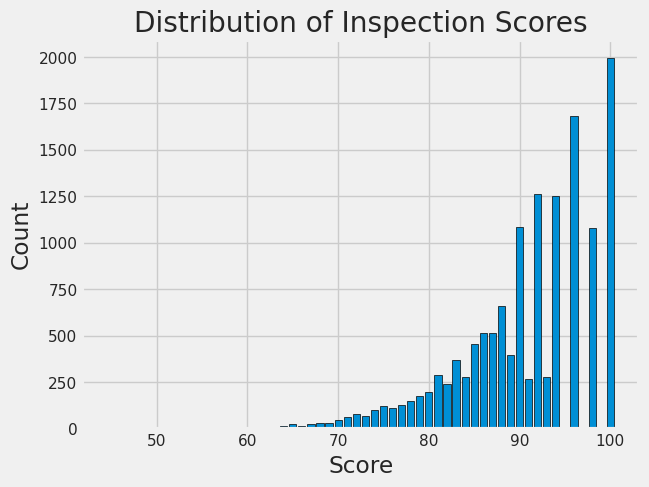

In [395]:
x = ins[ins["score"] > 0]["score"].value_counts().index
y = ins[ins["score"] > 0]["score"].value_counts()
plt.bar(x, y, edgecolor = "black")
plt.xlabel("Score"), plt.ylabel("Count")
plt.title("Distribution of Inspection Scores")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/><br/><br/>

---

### Question 5b

Now let's actually reflect on the histogram that we generated before with a bin size of 1.

Describe the qualities of the distribution of the inspections scores based on your bar plot. Consider the mode(s), symmetry, tails, gaps, and anomalous values. Are there any unusual features of this distribution? What do your observations imply about the scores?


The distribution is skewed to the left and there are gaps between bars starting from 100 up to 80, perhaps, the inspection violations is deducted by even numbers rather than odd numbers, like 2, 4, 6 etc. Also, the distribution has a peak of 100 which is called a unimodel distribution in statistics.

<!-- END QUESTION -->

<br/><br/><br/><br/>

---

<br/><br/>

## 6: Restaurant Ratings Over Time

Let's consider various scenarios involving restaurants with multiple ratings over time.



<br/><br/><br/>

---

### Question 6a

As a somewhat contrived exercise in data manipulation, let's see which restaurant location has had the most extreme improvement in its scores. Let the "swing" of a restaurant location be defined as the difference between its highest-ever and lowest-ever score. **Only consider restaurant locations with at least 3 scores—that is, restaurants that were rated at least 3 times.** Using whatever technique you want to use, assign `max_swing` to the name of restaurant that has the maximum swing.

*Note*: The "swing" is of a specific restaurant locations. There might be some restaurants with multiple locations; each location has its own "swing".


In [396]:
x = ins_named['score'].groupby(ins_named['bid']).agg(lambda x : max(x) - min(x))
max_swing = pd.concat([bus.set_index('bid'), x], axis=1).sort_values("score", ascending=False).iloc[0]["name"]
max_swing

'Lollipot'

In [397]:
grader.check("q6a")

q6a results: All test cases passed!

<br/><br/><br/>

---


### Question 6b

The city would like to know if food safety inspections work. This is a pretty vague and broad question. Such questions are common in the field of data science! 

In part 6b and 6c we'll explore one possible way to explore this question just using the data we have available.

Specifically, we'll ask: What's the relationship between the first and second scores for the businesses with 2 inspections in a year? Do they typically improve? What can we say about restaurants that initially failed? For simplicity, let's focus on only 2018 for this problem, using the `ins2018` DataFrame that will be created for you below.

In the following cell, we create a DataFrame called `scores_pairs_by_business` indexed by `bid` (containing only businesses with exactly 2 inspections in 2018). This DataFrame contains the field score_pair consisting of the score pairs ordered chronologically: `[first_score, second_score]`.

In [398]:
ins2018 = ins[ins['year'] == 2018]

two_score_businesses = (ins2018.sort_values('date')
                            .loc[:, ['bid', 'score']]
                            .groupby('bid')
                            .filter(lambda group: len(group)==2)
                       )

first_scores = two_score_businesses.groupby("bid").first()
second_scores = two_score_businesses.groupby("bid").last()

scores = pd.merge(first_scores, second_scores, on = "bid") \
                        .rename(columns = {"score_x": "first score",
                                           "score_y": "second score"})                                                    

scores

,first score,second score
bid,,
48,94,87
66,98,98
146,81,90
184,90,96
273,83,84
...,...,...
95621,100,100
95628,75,75
95674,100,96


<!-- BEGIN QUESTION -->

Now let's make a scatter plot to display these pairs of scores. Include on the plot a reference line with slope 1 and y-intercept 0. Since restaurant scores bottom out at 45 points, we'll only focus on ratings between 45 and 100. Thus your reference line should start at `[45, 45]` and go up to `[100, 100].`

Create your scatter plot in the cell below. It does not need to look exactly the same (e.g., no grid) as the sample below, but make sure that all labels, axes and data itself are correct.

![](pics/7c.png)

Key pieces of syntax you'll need:

`plt.scatter` plots a set of points. Use `facecolors='none'` and `edgecolors='b'` to make circle markers with blue borders. 

`plt.plot` for the reference line. Using the argument `r` will make the line red.

`plt.xlabel`, `plt.ylabel`, `plt.axis`, and `plt.title`.



Text(0, 0.5, 'Second Score')

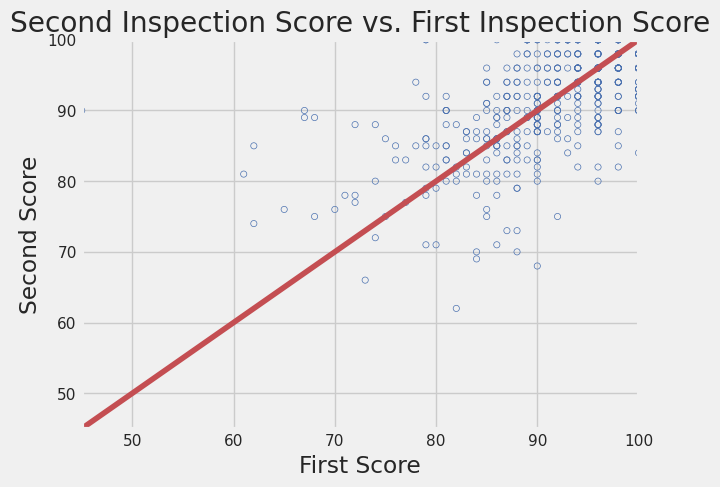

In [399]:
a = scores["first score"]
b = scores["second score"]
plt.axis([45,100,45,100])
plt.plot([45,100],[45,100], 'r')

plt.scatter(a,b,s = 20, facecolors='none',edgecolors='b')
plt.title("Second Inspection Score vs. First Inspection Score");
plt.xlabel('First Score')
plt.ylabel('Second Score')


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/><br/><br/>


---


### Question 6c

If restaurants' scores tend to improve from the first to the second inspection, what do you expect to see in the scatter plot that you made in question 6b? What do you oberve from the plot? Are your observations consistent with your expectations? 

Hint: What does the slope represent?


If the restaurants scores improved compatered to thier first inspection the points would moved above the line and vise versa. The points are surounded mostly on the top right of the scatter plot which means the most of the restaurants have good score compared to the few whose second scores are below 80. Overall, the scores seem good which means most of the restaurants care about food safety. 

<!-- END QUESTION -->

## Summary of Inspections Data

We have done a lot in this homework! Below are some examples of what we have learned about the inspections data through some cool visualizations!

- We found that the records are at the inspection level and that we have inspections for multiple years.
- We also found that many restaurants have more than one inspection a year.
- By joining the business and inspection data, we identified the name of the restaurant with the worst rating.
- We identified the restaurant that had the largest swing in rating over time.
- We also examined the change of scores over time! Many restaurants are not actually doing better.

## Congratulations! You have finished Homework 2! ##

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [400]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...

Your submission received the following results when run against available test cases:

    q1a results: All test cases passed!

    q1b results: All test cases passed!

    q1c results: All test cases passed!

    q2a results: All test cases passed!

    q2b results: All test cases passed!

    q2ci results: All test cases passed!

    q2cii results: All test cases passed!

    q2d results: All test cases passed!

    q2f results: All test cases passed!

    q3a results: All test cases passed!

    q3bi results: All test cases passed!

    q3ci results: All test cases passed!

    q3cii results: All test cases passed!

    q3ciii results: All test cases passed!

    q3civ results: All test cases passed!

    q3d results: All test cases passed!

    q4a results: All test cases passed!

    q4b results: All test cases passed!

    q4c results: All test cases passed!

    q6a results: All test cases passed!
